# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Подключение библиотек и загрузка данных

In [132]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

In [133]:
df = pd.read_csv("games.csv", sep=",")
display(df.head(10))
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Предобработка данных

**1. Заменим названия столбцов (приведем к нижнему регистру)**

In [134]:
print(df.columns)
df.columns = map(str.lower, df.columns)
print(df.columns)    

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')
Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


Привели все названия столбцов к нижнему регистру, в данном случае больше ничего менять не нужно.

**2. Преобразуем данные в нужные типы. Опишем, в каких столбцах заменили тип данных и почему**

Если взглянуть на таблицу, то бросается в глаза только тип данных в столбце `year_of_release`. Поменяем его на тип int, так как год не может быть не целым числом.

In [135]:
df['year_of_release'] = df['year_of_release'].astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


Больше проблем с типом данных в нашем датафрейме нет.

**3. Обработаем пропуски при необходимости:**
- Объясним, почему заполнили пропуски определённым образом или почему не стали это делать
- Опишем причины, которые могли привести к пропускам;
- Обратим внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберем это значение и опишем, как его обработать

In [136]:
df.isnull().sum()/len(df)*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

- Столбец `name`: Здесь всего 2 пропуска, которые возможно появились из-за технической ошибки или чьей-то невнимательности. Единственное решение убрать две данные строки. Исследованию это никак не навредит.
- Столбец `year_of_release` имеет всего 1,6% пропусков, возможно, что данные по году выпуска игры просто были утеряны. Заменять средним и медианным значением мы не можем, так как это будет некорректно. Правильным решением будет просто оставить данный столбец как есть
- Столбец `critic_score` имеет 51% пропусков. Это самое большое количество пропусков среди всех столбцов. Причиной их появления, по моему мнению то, что критики просто не оценивали половину игр из данного датафрейма. Возможно большая часть пропусков - это старые игры, и тогда никому это было не нужно. Здесь также нельзя заменить на среднюю или медиану, такая оценка будет необъективной и помешает исследованию. Для дальнейшей работы с датафреймом можно заменить пропуски на -1. Тогда данное значение не перепутается с нулевым рейтингом.
- Столбец `user_score` имеет 40% пропусков. Причиной их появления является то, что раньше не было сайтов, на которых сами игроки после некоторого прохождения могли написать отзыв на игру, как это происходит сейчас на площадках по типу Steam или Epic Games. Решение такое, как и для прошлого столбца.
- Столбец `rating` имеет почти 40,5% пропусков. Возможно раньше не было данной организации, которая ставит возрастной рейтинг для игр, поэтому в данном столбце столько пропусков. Хорошим вариантом будет оставить пропуски как есть, так как данный столбец никак не связан с другими и данные пропуски не помешают исследованию.

Посмотрим по очереди на каждый столбец в которых есть пропуски

Начнем со столбца `name`

In [137]:
print(df.query('name.isnull()', engine='python'))

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
14244  NaN      GEN             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


Как можно увидеть, в датафрейме всего 2 столбца с пропущенными именами. Я думаю, что их можно убрать без ущерба данным и исследованию.

In [138]:
df.dropna(subset=['name'], inplace=True)
df.reset_index(inplace=True,drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


Как можно увидеть, две данных строки убрались.


Столбец `year_of_release` имеет всего 1,6% пропусков, что очень мало по сравнению с количеством данных. К тому же данные целочисленные, замена средним значением или медианой здесь не подойдет. Оставим данные пропуски как есть, они не должны навредить исследованию.

Далее рассмотрим столбец `user_score`. Сначала разберемся с его типом данных. Он типа object, хотя должен быть float.

In [139]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Здесь присутствует некая аббревиатура tbd. Я думаю, что ее можно заменить на Nan, а затем поменять тип данных на float.

In [140]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN)
df['user_score'] = df['user_score'].astype('float')
display(df)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16709,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Теперь поменяем пропуски на -1, как мы рассуждали вначале.

**При попытке такой замены, я не знаю по какой причине, но столбец user_score становился копией critic_score. Поэтому я убрал данную замену из-за этой ошибки**


Как мы видим теперь пропусков нет.

**4. Посчитаем суммарные продажи во всех регионах и запишите их в отдельный столбец.**

In [141]:
df['sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


**5. Проверим наличие неявных дубликатов**

In [142]:
duplicates = df[df.duplicated(['name', 'platform', 'year_of_release'], keep=False)]
print(duplicates)

                name platform  year_of_release   genre  na_sales  eu_sales  \
604    Madden NFL 13      PS3             2012  Sports      2.11      0.22   
16228  Madden NFL 13      PS3             2012  Sports      0.00      0.01   

       jp_sales  other_sales  critic_score  user_score rating  sales  
604         0.0         0.23          83.0         5.5      E   2.56  
16228       0.0         0.00          83.0         5.5      E   0.01  


Как можно увидеть, в датафрейме есть две одинаковые игры с одним названием, годом выпуска и одной платформой, но у одной из них практически нет продаж. Удалим данную строку из датафрейма.

In [143]:
df.drop_duplicates(subset=['name', 'platform', 'year_of_release'], inplace=True)

Теперь мы избавились от такого вида дубликатов

**Вывод**

В данном разделе привели названия столбцов к нижнему регистру и поменяли типы данных в столбцах, которые в этом нуждались. Также убрали и заменили пропуски в нужных столбцах. Мои рассуждения по этому поводу написаны в начале раздела. Также добавили новый столбец с суммарными продажами во всех регионах.


# Исследовательский анализ данных

**1. Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?**

,year,count
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


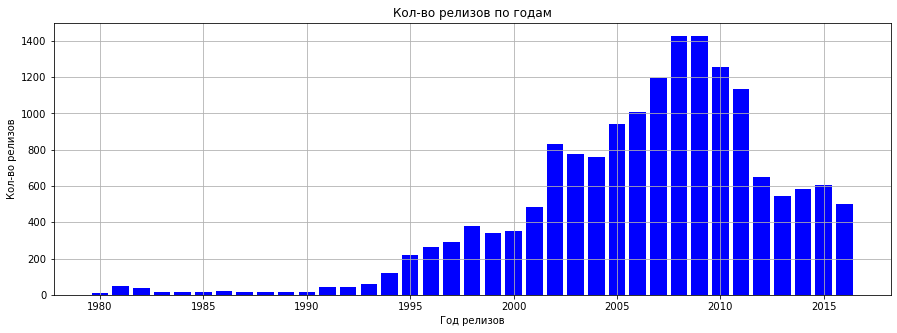

In [144]:
game_count = df.groupby('year_of_release')['name'].count().reset_index()
game_count.columns = ['year', 'count']
display(game_count)
plt.figure(figsize=(15, 5))
plt.bar(game_count['year'], game_count['count'], label='Кол-во релизов за год', color='b')
plt.xlabel('Год релизов')
plt.ylabel('Кол-во релизов')
plt.grid()
plt.title(f'Кол-во релизов по годам')
plt.show()

**Вывод**

Как видно из графика и таблицы, до 1990 года количество выпущенных игр было очень маленьким, после этого наступает эпоха компьютеров и игровых приставок. Игры на них начинают все больше выходить. Пик приходится на 2008 и 2009 года, было выпущено больше 1400 игр, затем их количество падает. 

**2. Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?**

In [145]:
platform = df.groupby('platform')['sales'].sum().sort_values(ascending = False).reset_index()
display(platform.head(20))

,platform,sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.64
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85
7,PS4,314.14
8,PSP,294.05
9,PC,259.52


array(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'], dtype=object)

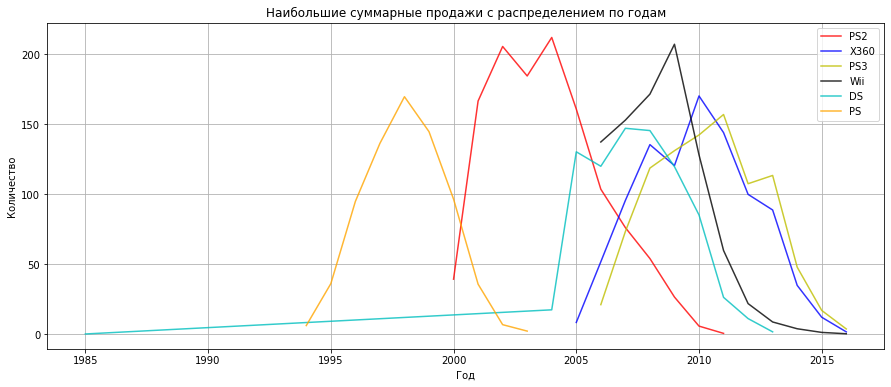

In [146]:
top_platforms = platform.loc[0:5, 'platform'].values
display(top_platforms)
color = ['r','b','y','black','c','orange','grey','green','brown','purple','m','pink','yellow','coral','darkcyan','dimgray','lime']
plt.figure(figsize=(15, 6))
plt.grid()
plt.title('Наибольшие суммарные продажи с распределением по годам')
mean_year_life = 0
for i in range(0,len(top_platforms)):
    platform1  = df.query('platform == @top_platforms[@i]').groupby('year_of_release')['sales'].sum()
    mean_year_life += platform1.count()
    platform1.plot(x=platform1.index, y=platform1.values, style='-', color=color[i], label=top_platforms[i], alpha=0.8, grid=True);
plt.xlabel('Год')    
plt.ylabel('Количество')
plt.legend()
plt.show()

Посмотрим за какой характерный срок появляются новые и исчезают старые платформы

In [147]:
print(mean_year_life/len(top_platforms))

11.166666666666666


Как видно на графике, те устройства, которые появились в 2000 году практически не использовались после 2010 году. Аналогично происходило и с устройствами которые появились в 2005 году. То есть получаем, что все приставки жили в основном чуть больше 10 лет. Самыми популярными устройствами были PS2, Xbox360 и PS3. Они до сих пор остаются на уровне легендарных устройств.

**3. Возьмем данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.**

Возьмем в качестве акутального периода, период развития приставок, то естьдо того, как они достигли пика популярности. Это будет период с 2012 года по 2016 год.

In [148]:
platform_2017 = df.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum').query('year_of_release >= 2012 & year_of_release <= 2016').fillna(0).reset_index()
platform_2017['year_of_release'] = platform_2017['year_of_release'].astype('Int64')
for column in platform_2017.columns:
    if platform_2017[column].sum()==0:
        platform_2017.drop(column, axis=1,inplace=True)
display(platform_2017)

platform,year_of_release,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
0,2012,51.36,11.01,23.22,107.35,0.00,7.69,16.19,21.71,17.56,99.74,0.00
1,2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2,2014,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
3,2015,27.78,0.00,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
4,2016,15.14,0.00,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


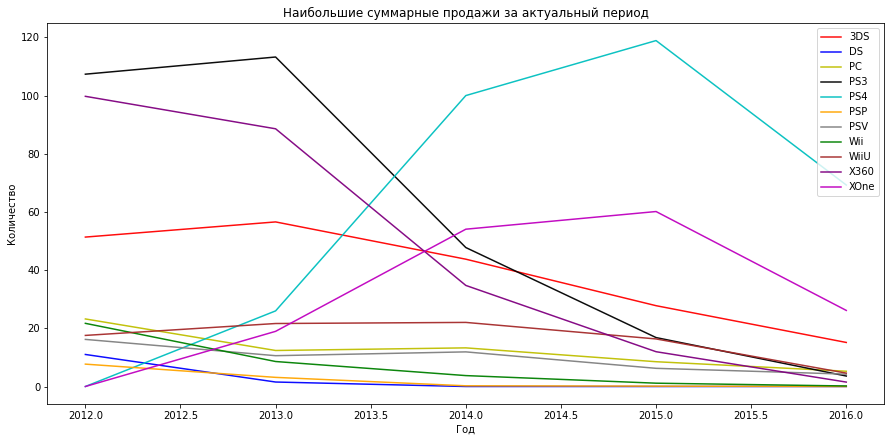

In [149]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.title('Наибольшие суммарные продажи за актуальный период')
i=0
for column in platform_2017.columns[1:]:
    plt.plot(platform_2017['year_of_release'].to_list(), platform_2017[column].to_list(), label=column, color=color[i], alpha=0.95);
    i+=1 
plt.grid()
plt.xlabel('Год')    
plt.ylabel('Количество')
plt.legend()
plt.show()

По данным из графика, можно увидеть, что во все времена существовали некоторые флагманские устройства, которые доминировали и покупались людьми во все года. К ним относятся PS2, Xbox360, Wii и PS3. Закат этих моделей как раз таки приходится на примерно на 2014 год, когда на замену этим приставкам пришли PS4 и XboxOne.

То есть если создавать некоторый топ устройств, то сначала идут флагманские устройства от гигантов индустрии, которые актуальны сейчас. Это PS4 и XboxOne. Затем предущие их версии, ведь люди же не будут их выбрасывать и сразу же покупать новые версии, поэтому в топе остаются также PS3 и Xbox360. Также можем выделить приставку Wii.

In [150]:
top_platform_2017 = df.query('year_of_release >= 2012 & year_of_release <= 2016', engine='python').groupby('platform')['sales'].sum().sort_values(ascending=False).reset_index()
display(top_platform_2017.head(10))

,platform,sales
0,PS4,314.14
1,PS3,288.78
2,X360,236.54
3,3DS,194.61
4,XOne,159.32
5,WiiU,82.19
6,PC,62.65
7,PSV,49.18
8,Wii,35.37
9,DS,12.55


**4. Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.**

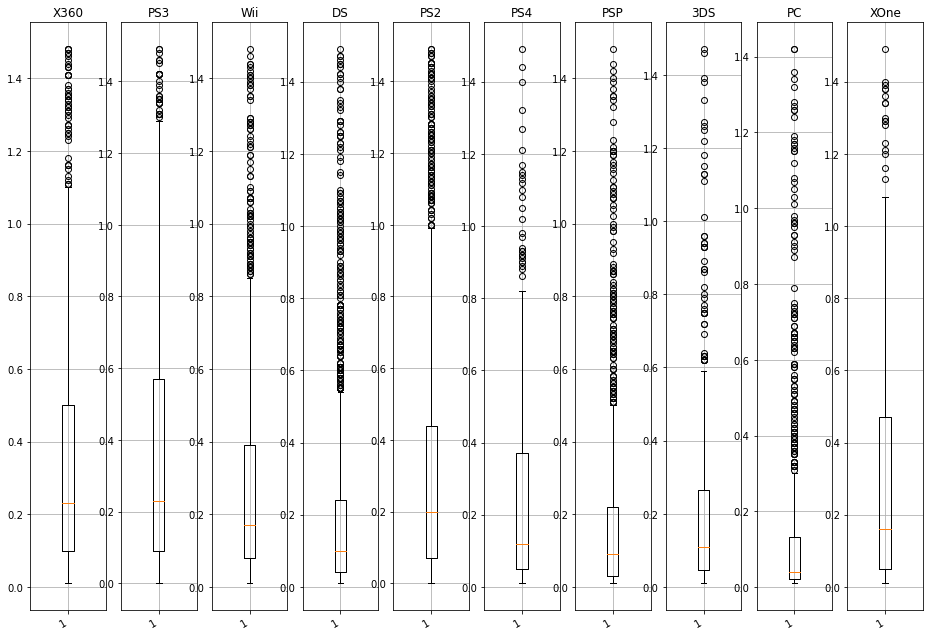

In [151]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(nrows=1, ncols=10, figsize=(16, 12))
fig.autofmt_xdate();
p = {ax1:'X360', ax2:'PS3', ax3:'Wii', ax4:'DS', ax5:'PS2', ax6:'PS4', ax7:'PSP', ax8:'3DS', ax9:'PC', ax10:'XOne'}
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]:
    sales = df.query('platform==@p[@ax] and sales<1.5', engine='python')['sales']
    ax.boxplot(sales)
    ax.grid()
    ax.set_title(p[ax])
fig.autofmt_xdate()

Как можно увидеть на ящиках с усами, медианные значения лежат в промежутке от 0,1 до 0,25 млн. Также можно увидеть огромное количество выбросов, точнее количество продаваемых игр на данную платформу. Лидерами тут несомненно будут PS2, PS3, Xbox360, а также Wii.

**5. Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.**

Возьмем популярную платформу PS2

In [152]:
ps = df[(df['platform'] == 'PS2') & (df['critic_score'] > 0)]
display(ps)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
17,Grand Theft Auto: San Andreas,PS2,2004,Action,9.43,0.40,0.41,10.57,95.0,9.0,M,20.81
24,Grand Theft Auto: Vice City,PS2,2002,Action,8.41,5.49,0.47,1.78,95.0,8.7,M,16.15
28,Gran Turismo 3: A-Spec,PS2,2001,Racing,6.85,5.09,1.87,1.16,95.0,8.4,E,14.97
38,Grand Theft Auto III,PS2,2001,Action,6.99,4.51,0.30,1.30,97.0,8.5,M,13.10
48,Gran Turismo 4,PS2,2004,Racing,3.01,0.01,1.10,7.53,89.0,8.5,E,11.65
...,...,...,...,...,...,...,...,...,...,...,...,...
16285,Metal Slug Anthology,PS2,2007,Shooter,0.00,0.00,0.01,0.00,80.0,8.1,T,0.01
16427,Greg Hastings' Tournament Paintball Max'd,PS2,2006,Shooter,0.01,0.00,0.00,0.00,70.0,9.2,E10+,0.01
16437,Ultimate Board Game Collection,PS2,2006,Misc,0.01,0.00,0.00,0.00,37.0,NaN,E,0.01
16505,World Heroes Anthology,PS2,2007,Fighting,0.00,0.00,0.01,0.00,53.0,NaN,T,0.01


Посмотрим как коррелируют продажи данной платформы и отзывы покупателей и критиков.

In [153]:
print(ps['sales'].corr(ps['critic_score']))
print(ps['sales'].corr(ps['user_score']))

0.39543454945454865
0.16941987448591259


Как можно увидеть, зависимость прямая в обоих случаях, но отзывы критиков влияют средне на продажи, а вот в ситуации с покупателями зависимость слабая.

Посмотроим два графика для наглядности

Text(0, 0.5, 'Продажи')

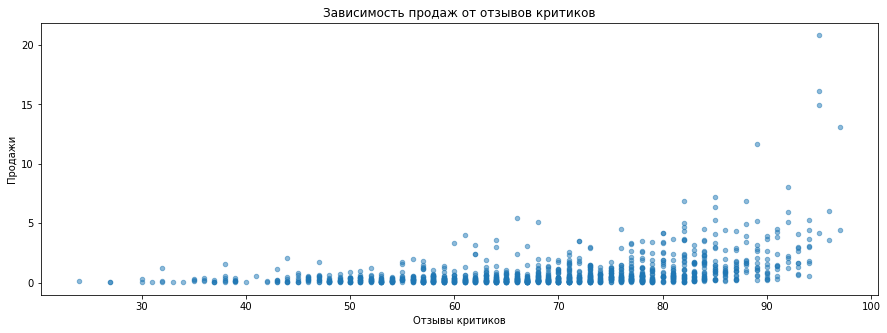

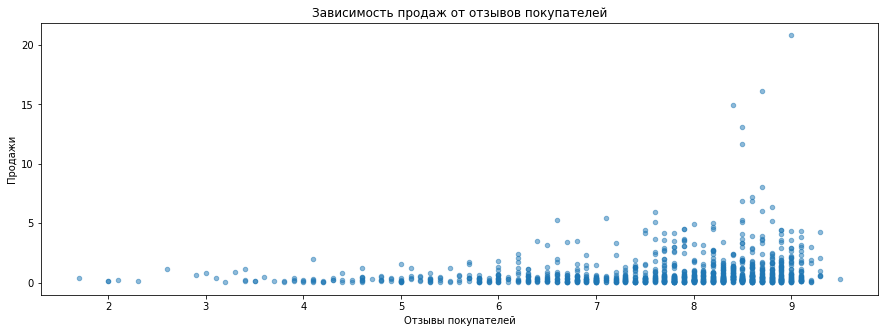

In [154]:
ps.plot(x='critic_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5)
plt.title('Зависимость продаж от отзывов критиков')
plt.xlabel('Отзывы критиков')
plt.ylabel('Продажи')
ps.plot(x='user_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5)
plt.title('Зависимость продаж от отзывов покупателей')
plt.xlabel('Отзывы покупателей')
plt.ylabel('Продажи')

Видно, что чем лучше оценки, тем лучше продажи, что достаточно логично.

**6. Соотнесите выводы с продажами игр на других платформах**

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
32,Call of Duty: Black Ops,X360,2010,Shooter,9.70,3.68,0.11,1.13,87.0,6.3,M,14.62
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
...,...,...,...,...,...,...,...,...,...,...,...,...
15741,Worms,X360,2007,Strategy,0.00,0.02,0.00,0.00,75.0,6.9,E10+,0.02
16309,Banjo-Kazooie,X360,2008,Platform,0.00,0.01,0.00,0.00,77.0,8.2,E,0.01
16472,John Daly's ProStroke Golf,X360,2010,Sports,0.01,0.00,0.00,0.00,57.0,NaN,E,0.01
16548,Superstars V8 Racing,X360,2009,Racing,0.00,0.01,0.00,0.00,62.0,NaN,E,0.01


0.3937358653072583
0.11041150383472836


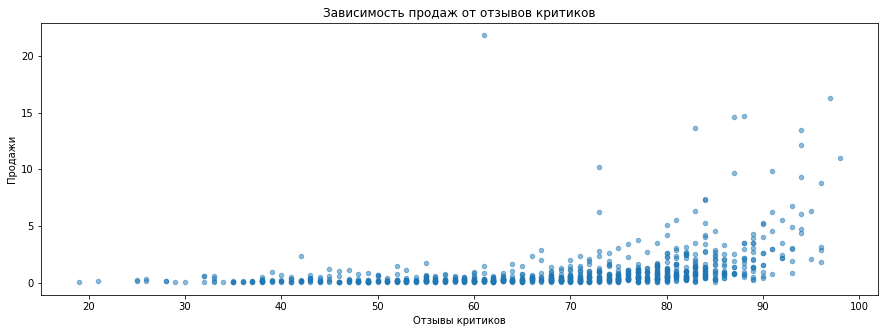

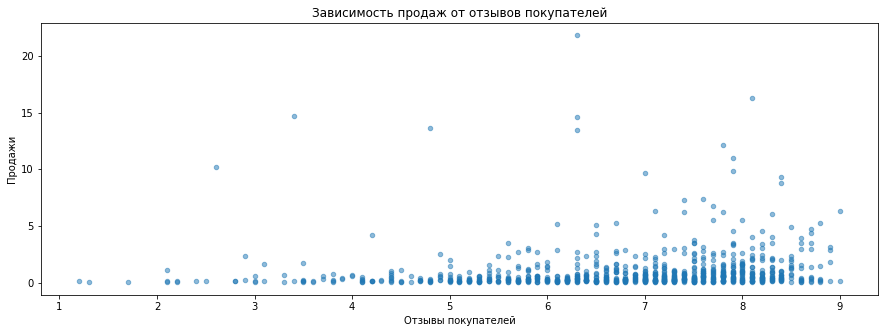

In [155]:
x = df[(df['platform'] == 'X360') & (df['critic_score'] > 0)]
display(x)
print(x['sales'].corr(x['critic_score']))
print(x['sales'].corr(x['user_score']))
x.plot(x='critic_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5);
plt.title('Зависимость продаж от отзывов критиков');
plt.xlabel('Отзывы критиков');
plt.ylabel('Продажи');
x.plot(x='user_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5);
plt.title('Зависимость продаж от отзывов покупателей');
plt.xlabel('Отзывы покупателей');
plt.ylabel('Продажи');

Ситуация крайне похожа, только отзывы покупателей влияют чуть меньше.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M,13.33
41,Call of Duty: Black Ops,PS3,2010,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M,12.63
54,Gran Turismo 5,PS3,2010,Racing,2.96,4.82,0.81,2.11,84.0,7.5,E,10.70
...,...,...,...,...,...,...,...,...,...,...,...,...
15565,Tom Clancy's Splinter Cell Classic Trilogy HD,PS3,2011,Action,0.02,0.00,0.00,0.00,67.0,6.8,M,0.02
15647,Darksiders,PS3,2010,Action,0.01,0.00,0.00,0.00,82.0,7.9,M,0.01
15740,Invizimals: The Lost Kingdom,PS3,2013,Action,0.00,0.02,0.00,0.00,50.0,5.0,E10+,0.02
15878,Turbo: Super Stunt Squad,PS3,2013,Sports,0.00,0.01,0.00,0.00,38.0,NaN,E,0.01


0.43337268693947606
0.1426647022635121


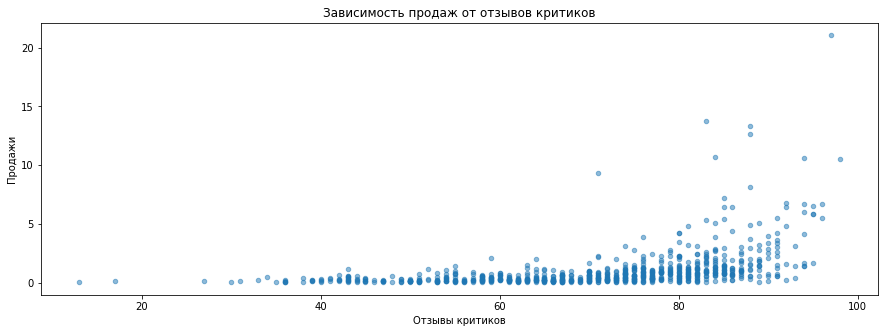

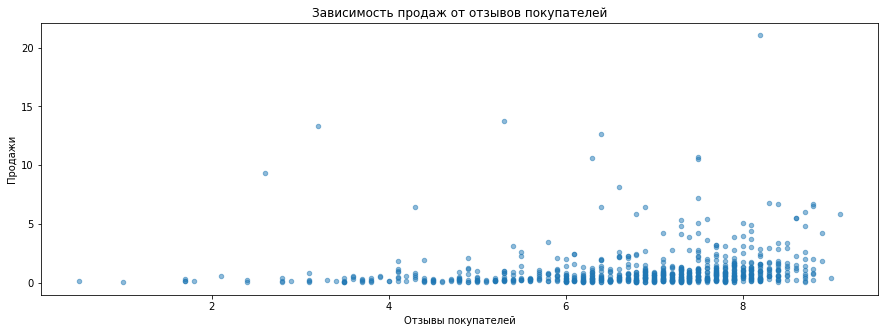

In [156]:
ps3 = df[(df['platform'] == 'PS3') & (df['critic_score'] > 0)]
display(ps3)
print(ps3['sales'].corr(ps3['critic_score']))
print(ps3['sales'].corr(ps3['user_score']))
ps3.plot(x ='critic_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5);
plt.title('Зависимость продаж от отзывов критиков');
plt.xlabel('Отзывы критиков');
plt.ylabel('Продажи');
ps3.plot(x ='user_score',y='sales',kind='scatter',figsize=(15,5), alpha=0.5);
plt.title('Зависимость продаж от отзывов покупателей');
plt.xlabel('Отзывы покупателей');
plt.ylabel('Продажи');

**Вывод**

Для всех платформ наблюдается общая тенденция. Зависимость продаж от отзывов критиков прямая и средняя, то есть около 0,4. Зависимость продаж от отзывов покупателей прямая и слабая(около 0,1). То есть можно сказать, что пользователи для которых делаются игры, никак не влияют на их продажу.

**7.Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

Посмотрим на количество игр и количество продаж по каждому жанру

In [157]:
genres_count = df.groupby('genre')['name'].count().sort_values(ascending=False)
genres_sales = df.groupby('genre')['sales'].sum().sort_values(ascending=False)
print(genres_count)
print(genres_sales)

genre
Action          3369
Sports          2347
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: name, dtype: int64
genre
Action          1744.17
Sports          1331.26
Shooter         1052.45
Role-Playing     934.56
Platform         827.77
Misc             802.51
Racing           728.67
Fighting         447.53
Simulation       389.97
Puzzle           242.57
Adventure        237.59
Strategy         174.23
Name: sales, dtype: float64


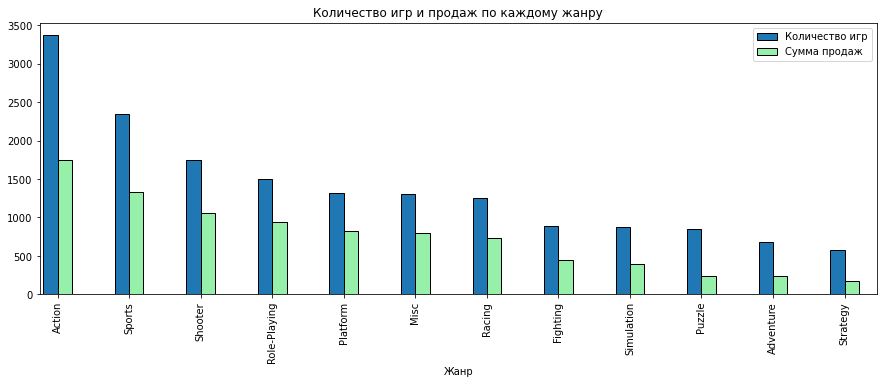

In [158]:
ax = plt.gca();
genres_count.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, position=1);
genres_sales.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='#97F0AA', position=0);
ax.legend(['Количество игр', 'Сумма продаж']);
ax.set_title('Количество игр и продаж по каждому жанру');
ax.set_xlabel('Жанр');

Преобладают жанры action, sports и shooter. Это достаточно логично, ведь на разработку игр в таких жанрах индустрия тратит сотни миллионов долларов, а их прохождение может занимать больше 50 часов. Меньше всего игр и продаж в жанрах puzzle, adventure и strategy.

Рассмотрим средние и медианные продажи с распределнием по жанрам.

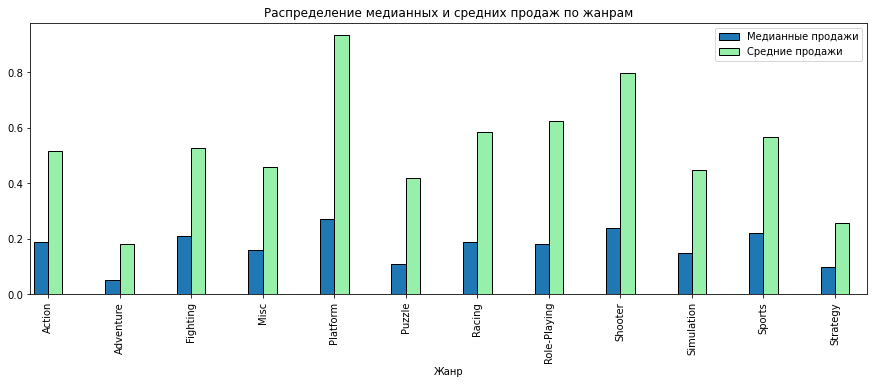

In [159]:
median_sales_by_genre = df.groupby('genre')['sales'].median()
mean_sales_by_genre = df.groupby('genre')['sales'].mean()
ax = plt.gca();
median_sales_by_genre.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, position=1);
mean_sales_by_genre.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='#97F0AA', position=0);
ax.legend(['Медианные продажи', 'Средние продажи']);
ax.set_title('Распределение медианных и средних продаж по жанрам');
ax.set_xlabel('Жанр');

Как мы знаем, средняя в отличие от медианы сильно зависит от выбросов, в нашем случае, выброс - это игра с большой суммой продаж во всех регионах. Как можно увидеть на графике, платформеры сильно обгоняют остальные жанры по средним и медианным продажам. Самый известный платформер - это Super Mario. Я думаю в нег играли большинство людей, кроме современного поколения. Также большие средние продажи имеет жанр shooter. В этом жанре выходило очень много игр бестселлеров, например, Call of Duty или Battlefield.

# Составление портрета пользователя каждого региона

**Все следующие пункты будут сделаны для пользователя каждого региона (NA, EU, JP)**

**1. Самые популярные платформы (топ-5). Опишем различия в долях продаж.**

Напишем функцию для составления графиков

In [160]:
def top_in_regions(groupby, region_sales, ax):
    pivot = df.query('year_of_release >= 2012 & year_of_release <= 2016', engine='python').groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    plot = pivot.plot(kind='bar', ec='black', ax=axes[ax])

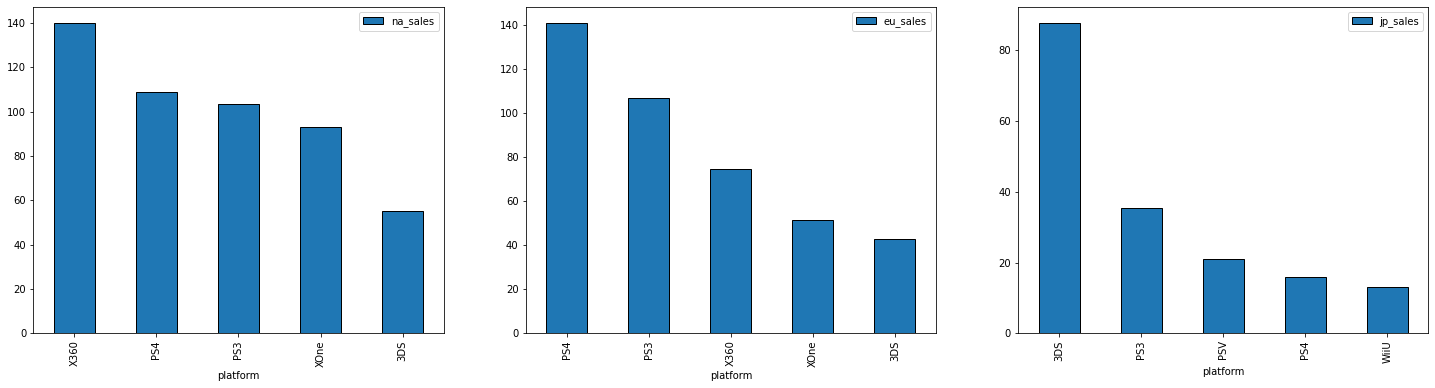

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions('platform', 'na_sales', 0)
top_in_regions('platform', 'eu_sales', 1)
top_in_regions('platform', 'jp_sales', 2)

Как можно увидеть, лидерами в Америке является Wii, затем идет почти на равне Xbox360, и потом DS. В Европе также ценят Wii. Там лидерами являются Wii, DS и PS3. В Японии же ситуация немного отличается, для них Xbox360 совсем уходит из топа. Лидерами являются DS, Wii и PS2.

**2. Самые популярные жанры (топ-5). Поясним разницу.**

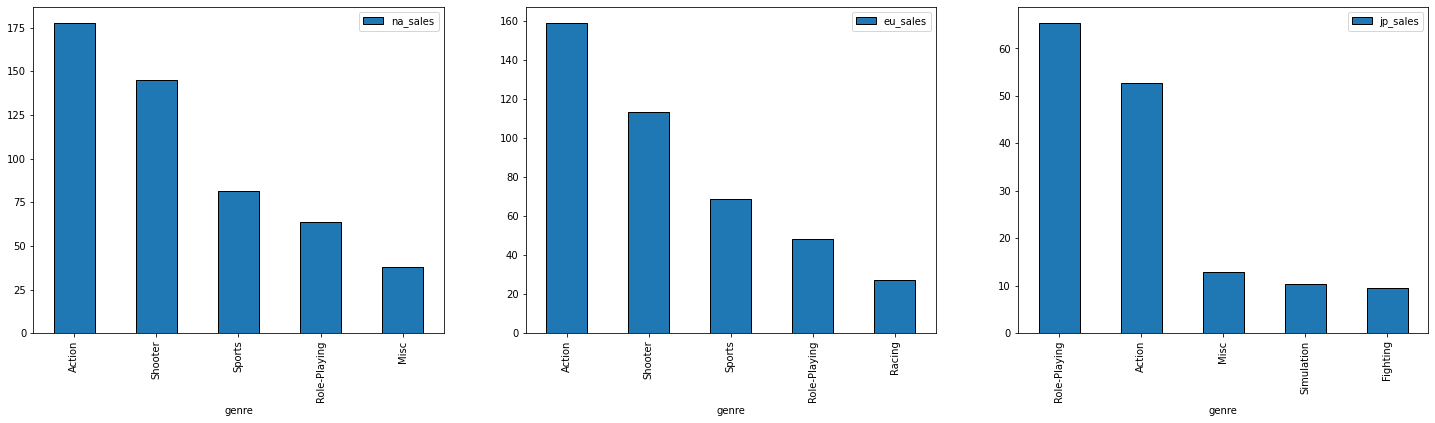

In [162]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions('genre', 'na_sales', 0)
top_in_regions('genre', 'eu_sales', 1)
top_in_regions('genre', 'jp_sales', 2)

В Америке и Европе играют в экшен, спортивные игры, шутеры и разное, то два данных региона похожи во вкусах на жанры игр. А вот в Японии с большим отрывом любят жанр ролевых игр, и только потом экшен и разное.

**3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?**

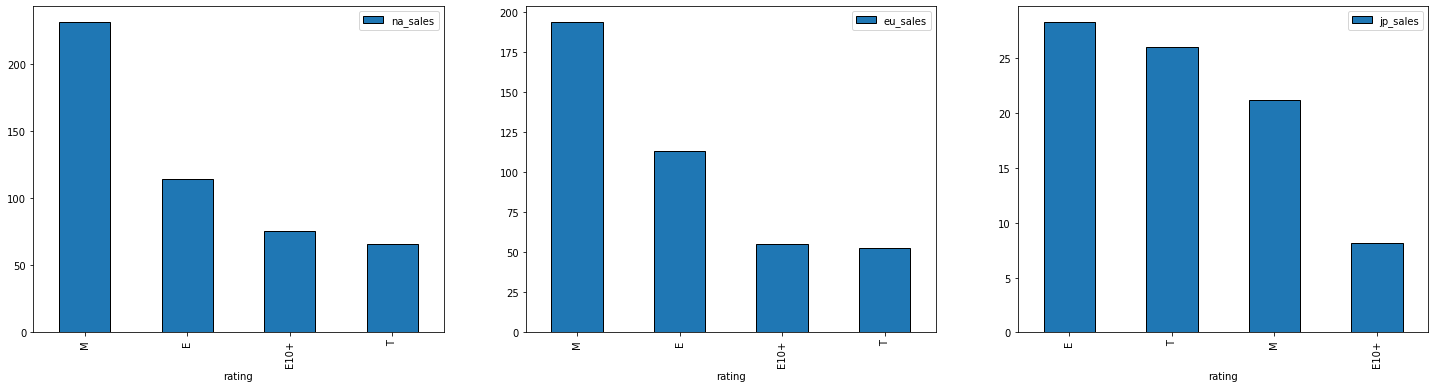

In [163]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions('rating', 'na_sales', 0)
top_in_regions('rating', 'eu_sales', 1)
top_in_regions('rating', 'jp_sales', 2)

Для начала расшифруем, что означают эти буквы:
- E - игры для всех возрастов
- Т - старше 13 лет
- М - старше 17 лет
- Е10+ - старше 10 лет
- К-А - расшифровывается как для детей и взрослых. Можно считать, что от 6 лет и старше.

Во всех регионах преобладают игры "для всех", "старше 13 лет" и "старше 17 лет". 

# Проверка гипотез

**1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Гипотеза H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотеза H1: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковы

Критическое значение возьмем равным 0.05

In [164]:
xbox_ratings = df[(df['platform'] == 'XOne') & (df['user_score'] > 0) & (df['year_of_release'] >= 2012) & (df['year_of_release'] <= 2016)]['user_score']
pc_ratings = df[(df['platform'] == 'PC') & (df['user_score'] > 0) & (df['year_of_release'] >= 2012) & (df['year_of_release'] <= 2016)]['user_score']
alpha = 0.05

results = st.ttest_ind(xbox_ratings, pc_ratings, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


P-value больше 0.05, значит, нулевая гипотеза принимается, то есть средние пользовательские рейтинги платформ Xbox One и PС одинаковые.

Посчитаем эти средние пользовательские рейтинги

In [165]:
print(xbox_ratings.mean())
print(pc_ratings.mean())

6.52142857142857
6.428640776699027


Как мы видим пользовательские рейтинги действительно одинаковые


**2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

Гипотеза H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые

Гипотеза H1: Средние пользовательские рейтинги жанров Action и Sports разные

Критическое значение возьмем равным 0.05

In [166]:
action_ratings = df[(df['genre'] == 'Action') & (df['user_score'] > 0) & (df['year_of_release'] >= 2012) & (df['year_of_release'] <= 2016)]['user_score']
pc_ratings = df[(df['genre'] == 'Sports') & (df['user_score'] > 0) & (df['year_of_release'] >= 2012) & (df['year_of_release'] <= 2016)]['user_score']
alpha = 0.05

results = st.ttest_ind(action_ratings, pc_ratings, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.804523380462917e-26
Отвергаем нулевую гипотезу


P-value больше 0.05, значит, нулевая гипотеза принимается и средние пользовательские рейтинги жанров Action и Sports одинаковые

# Вывод

В ходе исследования были проведены:
1) Предобработка данных

2) Исследовательский анализ данных

3) Составление портрета пользователя каждого региона

4) Проверка гипотез

**Предобработке данных:** привели названия столбцов к нижнему регистру, замены типы данных в столбцах и поработали с пропусками. Такжедобавили новый столбец с суммарными продажами со всех регионов.

**В исследовательском анализе данных выяснили:**
- Период компьютерных игр начался с 2000 года. Крупный рост и популярность игровых платформ пошли с 2005 года. 
- Средний срок существования платформы около 11 лет. 
- На момент 2017 года развивающиеся платформы - это PS4 и XboxOne. Эра прошлого поколения приставок к 2017 году уже подошла к концу. Платформа ПК будет актуальна всегда, поэтому игры на нее не перестают выпускать. 
- Также мы выяснили, что продажи прямопропорционально зависят от отзывов критиков, втоже же время присутствует слабая прямая зависимость между продажами и отзывами пользователей.
- В тройку лидеров по количеству игр по жанрам входят Action(20,2%), Sports(14%) и Sports(10,5%). В тройку лидеров по продажам игр по жанрам входят Action(19,6%), Sports(14,9%)и Shooter(11,8)

**Портрет пользователя каждого региона:**
- Лидерами в Америке является Xbox360, затем идет почти на равне PS2, и потом Wii. В Европе больше ценят Playstation. Там лидерами являются PS2, PS3 и Xbox360. В Японии же ситуация немного отличается, для них Xbox360 совсем уходит из топа. Лидерами являются DS, PS и PS2.
- В Америке и Европе играют в экшен, спортивные игры и шутеры, то два данных региона похожи во вкусах на жанры игр. А вот в Японии с большим отрывом любят жанр ролевых игр, и только потом экшен и спортивные игры.
- Во всех регионах преобладают игры "для всех", "старше 13 лет" и "старше 17 лет".

**Также была проведена проверка гипотез из которой мы выяснили, что:**
- средние пользовательские рейтинги платформ Xbox One и PС одинаковые
- Средние пользовательские рейтинги жанров Action и Sports одинаковые